# Maximum Likelihood Estimation: Bounded Power-law Distributions

In [10]:
import os
import sys

import numpy as np
import scipy.optimize
from astroML import density_estimation
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src'))
import ebtel_plot as ebp
%matplotlib inline

When estimating the slope of a supposed power-law distribution for limited sample size, using a log-transform combined with least-squares fitting can yield incorrect results (e.g. see [d'Huys et al., 2016](http://adsabs.harvard.edu/abs/2016arXiv160506972D)).

It is better instead to use __maximum likelihood estimation__ (or MLE) to estimate this slope $\alpha$. For a power-law distribution $p\sim x^{-\alpha}$ with a lower-bound of $x_{min}$, the estimate is simply,
$$
\hat{\alpha} = \sum_{i=1}^{n}\log\left(\frac{x_i}{x_{min}}\right) + 1.
$$

This assumes an upper bound of $\infty$. It turns out that for those distributions that have a finite upper bound (call it $x_{max}$), this estimate is not appropriate (e.g. see [Langlois et al., 2014](http://link.aps.org/doi/10.1103/PhysRevE.89.012709)). A power-law bounded by both $x_{min}$ and $x_{max}$ is given by
$$
p(x) = \frac{1-\alpha}{x_{max}^{1-\alpha} - x_{min}^{1-\alpha}}x^{-\alpha}.
$$

Calculating the probability $P(x|\alpha)$ of a given $\alpha$ and the log-likelihood function $\mathcal{L}$, one can calculate $\partial\mathcal{L}/\partial\alpha=0$ as, 
$$
0 = -\sum_{i=1}^{n}\log{x_i} + \frac{n}{\alpha - 1} + \frac{n}{x_{min}^{1-\alpha} - x_{max}^{1-\alpha}}(x_{min}^{1-\alpha}\log{x_{min}} - x_{max}^{1-\alpha}\log{x_{max}}).
$$

The value of $\alpha$ which most closely satisfies this expression (i.e. _maximizes_ the log-likelihood) is the best estimate of $\alpha$ for our distribution.

First, define a function for generating power-law distributions.

In [11]:
def pl_dist(xmin,xmax,alpha,x):
        return ((xmax**(-alpha+1) - xmin**(-alpha+1))*x + xmin**(-alpha+1))**(1/(-alpha+1))

Now, define a function that fits the data using a log-transform/least squares approch.

In [12]:
def graphical(x,noise_thresh=0.01,truncate=True):
    #Compute the histogram
    _,bins = density_estimation.freedman_bin_width(x,return_bins=True)
    hist,edges = np.histogram(x,bins=bins)
    centers = np.diff(edges)/2.0+edges[0:-1]
    #Filter
    noise = np.where(hist <= int(np.max(hist)*noise_thresh))
    if len(noise[0]) > 0 and truncate:
        hist = hist[0:noise[0][0]]
        centers = centers[0:noise[0][0]]
    #Log transform
    centers = np.log10(centers)
    hist = np.log10(hist)
    #Fit function
    def f(x,a,b):
        return a*x + b
    #Fitting
    pars,covar = scipy.optimize.curve_fit(f,centers,hist,sigma=np.sqrt(hist))
    #Uncertainty
    try:
        sigma = np.sqrt(np.diag(covar))
    except:
        sigma = [0.0,0.0]
        pass
    
    return {'alpha':pars[0],'sigma':sigma[0]}

Finally, define a function that uses our new numerical MLE method.

In [13]:
def mle(x,xmin,xmax,alpha_bounds=[1.1,10]):
    #define mle function
    def f_mle(alpha,xi,x_min,x_max):
        n = len(xi)
        term1 = -np.sum(np.log(xi))
        term2 = n/(alpha - 1.0)
        term3a = n/(x_min**(1.0-alpha) - x_max**(1.0-alpha))
        term3b = x_min**(1.0-alpha)*np.log(x_min) - x_max**(1.0-alpha)*np.log(x_max)
        return term1 + term2 + term3a*term3b
    
    x0,r = scipy.optimize.brentq(f_mle,alpha_bounds[0],alpha_bounds[1],args=(x,xmin,xmax),full_output=True)
    if r.converged:
        return {'alpha':x0}
    else:
        print('Minimization not sucessful. Returning None')
        return None

Now run the two methods for a range of sample sizes and a given $\alpha$ to see how they perform.

In [21]:
alpha = 1.5
a0,a1 = 0.0001,10.0
sample_size = np.logspace(2,7,100)
graphical_results,mle_results = [],[]
for s in sample_size:
    #Create distribution
    xpl = pl_dist(a0,a1,alpha,np.random.rand(s))
    #Graphical fitting
    pl_instance = ebp.Plotter()
    pl_instance.events = xpl
    result = pl_instance.plot_event_distribution(show_plot=False)
    graphical_results.append(result['graphical'])
    #graphical_results.append(graphical(xpl,truncate=True,noise_thresh=1e-6))
    #MLE
    mle_results.append(mle(xpl,np.min(xpl),np.max(xpl),alpha_bounds=[1.1,5]))

/opt/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda3/lib/python3.4/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


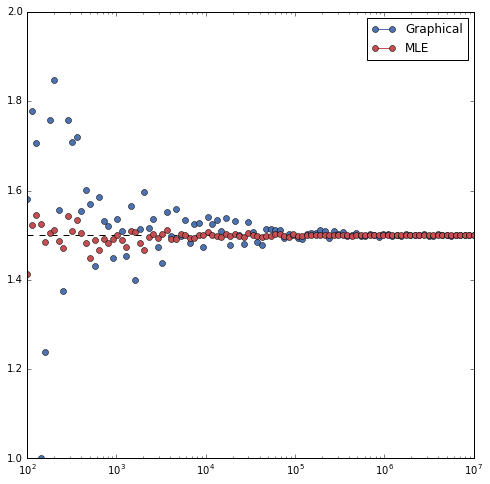

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.axhline(y=alpha,color='k',linestyle='--')
for i in range(len(sample_size)):
    graphical_line = ax.plot(sample_size[i],np.fabs(graphical_results[i]['alpha']),color=sns.color_palette('deep')[0],marker='o')
    mle_line = ax.plot(sample_size[i],mle_results[i]['alpha'],color=sns.color_palette('deep')[2],marker='o')
lines = graphical_line + mle_line
ax.legend(lines,[r'Graphical',r'MLE'],loc='best')
ax.set_ylim([1,2])
ax.set_xscale('log')